In [145]:
import gzip
import collections
from sklearn import linear_model
from sklearn import metrics
import random
import numpy as np
import string
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd 
import re
from sklearn.model_selection import train_test_split

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt', encoding='utf-8'):
        if 'null' not in l:
            yield eval(l)

In [3]:
all_cloth = list(readGz("renttherunway_final_data.json.gz"))

In [4]:
all_cloth[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [5]:
len(all_cloth)

192462

In [6]:
for item in all_cloth:
    keys_with_spaces = list(item.keys())  # Extracting keys to modify while iterating
    for key in keys_with_spaces:
        if ' ' in key:
            new_key = key.replace(' ', '_')  # Replacing spaces with underscores
            item[new_key] = item.pop(key)  # Replace the key in the dictionary

In [7]:
all_cloth[0]

{'fit': 'fit',
 'user_id': '420272',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust_size': '34d',
 'rented_for': 'vacation',
 'body_type': 'hourglass'}

In [8]:
#Data cleaning:
#1: We noticed that some clothing data between user and item is incomplete
cloths_key_len = []
for item in all_cloth:
    cloths_key_len.append(len(item.keys()))


In [9]:
#Incomplete clothing data for the item if the item has less than the standard 15 variables to describe it. 
unique_values = list(set(cloths_key_len))
print(unique_values)

[12, 13, 14, 15]


In [10]:
#Cleaned Dataset 
cloth_cleaned = []
for item in all_cloth:
    if len(item.keys()) == 15:
        cloth_cleaned.append(item)
len(cloth_cleaned)

146381

In [11]:
cloth_cleaned[0]

{'fit': 'fit',
 'user_id': '420272',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust_size': '34d',
 'rented_for': 'vacation',
 'body_type': 'hourglass'}

In [12]:
#User item pair for recommendation:
user_dict = defaultdict(list)
for item in cloth_cleaned:
    user_dict[item['user_id']].append(item['item_id'])

In [13]:
#Different occasions of clothes
cloth_occasions = []
for item in cloth_cleaned:
    cloth_occasions.append(item['rented_for'])

In [14]:
unique_occasions = list(set(cloth_occasions))
print(unique_occasions)

['formal affair', 'work', 'everyday', 'wedding', 'other', 'party: cocktail', 'date', 'party', 'vacation']


In [15]:
len(unique_occasions)

9

# Explore Dataset

In [16]:

# count occasion
occasions_num = defaultdict(int)
for x in cloth_cleaned:
    occasions_num[x['rented_for']] += 1
occasions_num = dict(sorted(occasions_num.items(), key=lambda item: item[1]))
temp = occasions_num.pop('other')
occasions_num['other'] = temp
occasions_num.pop('party: cocktail')
print(occasions_num)

# count ratings
rating_num = defaultdict(int)
for x in cloth_cleaned:
    rating_num[int(x['rating'])] += 1
rating_num = dict(sorted(rating_num.items(), key=lambda item: item[0]))
print(rating_num)

# count fit
fit_num = defaultdict(int)
for x in cloth_cleaned:
    fit_num[x['fit']] += 1
fit_num['fit'] = fit_num.pop('fit')
fit_num['large'] = fit_num.pop('large')
print(fit_num)

{'vacation': 3238, 'date': 5929, 'work': 12124, 'everyday': 13263, 'party': 27198, 'formal affair': 30496, 'wedding': 42622, 'other': 11510}
{2: 783, 4: 2205, 6: 8341, 8: 40761, 10: 94291}
defaultdict(<class 'int'>, {'small': 19622, 'fit': 107733, 'large': 19026})


Text(0.5, 1.0, 'Figure 1: Fit Distribution')

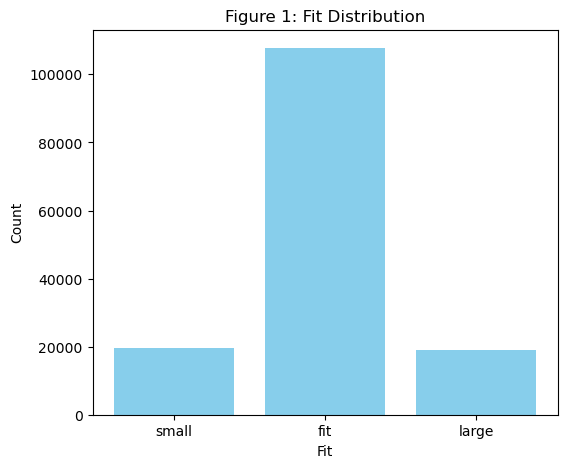

In [17]:
labels = list(fit_num.keys())
values = list(fit_num.values())

plt.figure(figsize=(6, 5))
plt.bar(labels, values, color='skyblue')
plt.ylabel('Count')
plt.xlabel('Fit')
plt.title('Figure 1: Fit Distribution')

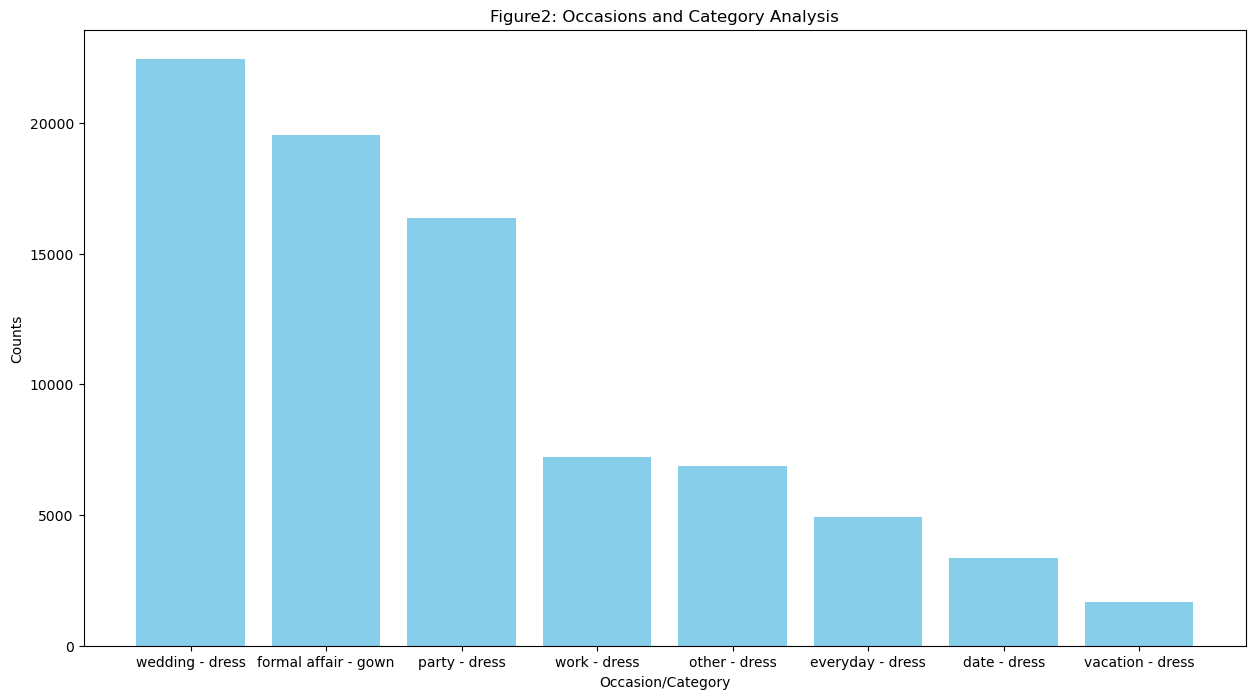

In [18]:
rented_for_category_counts = {}

for x in cloth_cleaned:
    rented_for = x['rented_for']
    category = x['category']
    
    # Creating a combined key for rented_for and category
    combined_key = f"{rented_for} - {category}"
    
    rented_for_category_counts[combined_key] = rented_for_category_counts.get(combined_key, 0) + 1

sorted_counts = dict(sorted(rented_for_category_counts.items(), key=lambda item: item[1], reverse=True))
unique = []
unique_occ_cat_count = {}
for x in sorted_counts:
    occ =  x.split('-')[0]
    if occ not in unique:
        unique.append(occ)
        unique_occ_cat_count[x] = sorted_counts[x]
unique_occ_cat_count.pop('party: cocktail - dress')

plt.figure(figsize=(15, 8))
plt.bar(unique_occ_cat_count.keys(), unique_occ_cat_count.values(), color='skyblue')
plt.title('Figure2: Occasions and Category Analysis')
plt.xlabel('Occasion/Category')
plt.ylabel('Counts')
plt.show()

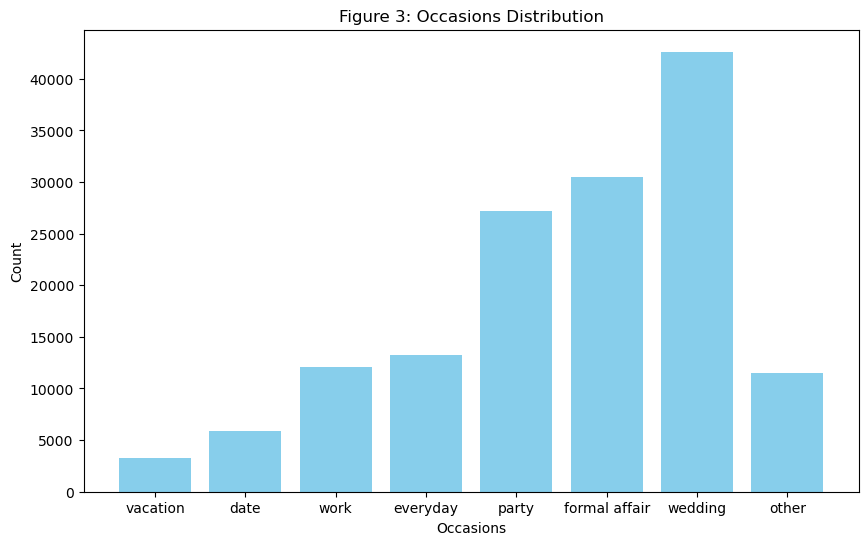

In [19]:
labels = list(occasions_num.keys())
values = list(occasions_num.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.ylabel('Count')
plt.xlabel('Occasions')
plt.title('Figure 3: Occasions Distribution')

plt.show()

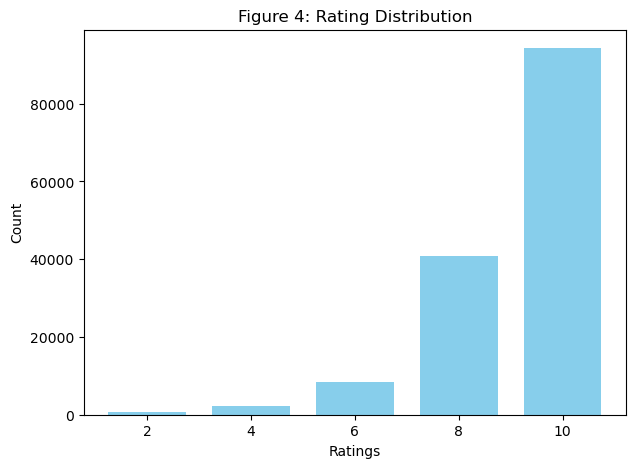

In [20]:
labels = list(rating_num.keys())
values = list(rating_num.values())

plt.figure(figsize=(7, 5))
plt.bar(labels, values, color='skyblue', width=1.5)
plt.ylabel('Count')
plt.xlabel('Ratings')
plt.title('Figure 4: Rating Distribution')


plt.show()

# Modeling

## Baseline Models

In [21]:
#Baseline Model #1: Model always predict fit
always_fit = len(cloth_cleaned) #
always_fit

146381

In [22]:
#Baseline Model #1 accuracy:
prediction_b1 = 0 #Counter for crrrect prediction of fit.
for cloth in cloth_cleaned:
    if cloth['fit'] == 'fit':
        prediction_b1 += 1
prediction_b1

107733

In [23]:
#Baseline Model #1 accuracy: Number of correct base prediction in dataset('fit') / length of dataset(assuming all fit)
accuracy_b1 = prediction_b1 / always_fit
accuracy_b1

0.7359766636380405

In [24]:
#Baseline Model #2: Using size as the factor to predict fit
prediction_b2 = 0 #Counter for crrrect prediction of fit.
for cloth in cloth_cleaned:
    if cloth['size'] >= 5 and cloth['size'] <= 40:
        prediction_b2 += 1
prediction_b2

108147

In [25]:
#Baseline Model #1 accuracy:
accuracy_b2 = prediction_b2 / len(cloth_cleaned)
accuracy_b2

0.7388048995429735

### Enhanced Modeling

In [146]:
def standardize_data(data):
    """
    Standardizes the clothing dataset in place, focusing on bust size and height.

    Parameters:
    data (list of dict): List of dictionaries containing clothing item and user information.
    """
    for entry in data:
        # Standardizing bust size
        if 'bust_size' in entry and isinstance(entry['bust_size'], str):
            bust_match = re.match(r'(\d+)([a-zA-Z]+)', entry['bust_size'])
            if bust_match:
                entry['bra_size'] = int(bust_match.group(1))
                entry['cup_size'] = bust_match.group(2)

        # Converting height to inches
        if 'height' in entry and isinstance(entry['height'], str):
            height_match = re.match(r"(\d+)' (\d+)", entry['height'])
            if height_match:
                feet, inches = height_match.groups()
                entry['height_inches'] = int(feet) * 12 + int(inches)
        # Converting weight to integer
        if 'weight' in entry and isinstance(entry['weight'], str):
            weight_match = re.match(r'(\d+)', entry['weight'])
            if weight_match:
                entry['weight_int'] = int(weight_match.group(1))

In [147]:
standardize_data(cloth_cleaned)

In [148]:
cloth_cleaned[0]

{'fit': 'fit',
 'user_id': '420272',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust_size': '34d',
 'rented_for': 'vacation',
 'body_type': 'hourglass',
 'bra_size': 34,
 'cup_size': 'd',
 'height_inches': 68,
 'weight_int': 137}

In [149]:
#Feature function for logistic Regression
def feat(cloth):
    #fit:
    fit = -1 #Default, for counter
    if item['fit'] == 'small':
        fit = 0
    elif item['fit'] == 'fit':
        fit = 1
    else:
        fit = 2
        
    #bra
    bra = int(item['bra_size'])
    #Cup
    cup = item['cup_size']
    cup_dict = {'a':0, 'aa':1, 'b':2, 'c':3, 'd':4, 'dd':5, 'ddd':6, \
               'f':7, 'g':8, 'h':9, 'i':10, 'j':11}
    cp = cup_dict[cup]
    
    
    #weight
    weight =  item['weight_int']
    # rating
    rating = int(item['rating'])
    #height in inches
    height_inches = int(item['height_inches'])
    # size
    size = item['size']
    # age
    age = int(item['age'])
    #rented_for
    rented_for = item['rented_for']
    rf_dict = {'date':0, 'everyday':1, 'formal affair':2, 'other':3, 'party':4, 'party: cocktail':5, 'vacation':6, \
               'wedding':7, 'work':8}
    rf = rf_dict[rented_for]
    
    #body type
    body_type = item['body_type']
    bt_dict = {'apple':0, 'athletic':1, 'full bust':2, 'hourglass':3, 'pear':4, 'petite':5, 'straight & narrow':6}
    bt = bt_dict[body_type]
    
    return [1, bra, cp, weight, rating, height_inches, size, age, rf, bt], fit

In [150]:
#Create features
X_lst = []
y_lst = []
for item in cloth_cleaned:
    X, y = feat(item)
    X_lst.append(X)
    y_lst.append(y)
y_lst[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 2]

In [151]:
X_train, X_temp, y_train, y_temp = train_test_split(X_lst, y_lst, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [152]:
len(X_train), len(X_val), len(X_test)

(117104, 14638, 14639)

In [153]:
len(y_train), len(y_val), len(y_test)

(117104, 14638, 14639)

In [154]:
mod = linear_model.LogisticRegression(C=1)
mod.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [155]:
pred = mod.predict(X_test)

In [156]:
correct = pred == y_test
accuracy = sum(correct) / len(correct)
accuracy

0.7381651752168864

In [39]:
#Using class_weight = balanced yield to very low accuracy
#About 0.53
# mod1_2 = linear_model.LogisticRegression(C=1, class_weight = 'balanced')
# mod1_2.fit(X_train, y_train)
# pred1_2 = mod1_2.predict(X_test)
# correct = pred1_2 == y_test
# accuracy = sum(correct) / len(correct)
# accuracy

## SVM: Linear Support Vector Machine

In [142]:
punct = set(string.punctuation)
texts = []
texts_sum = []
for x in cloth_cleaned:
    texts.append(''.join([c for c in x['review_text'].lower() if not c in punct]))
    texts_sum.append(''.join([c for c in x['review_summary'].lower() if not c in punct]))

In [161]:
X_train, X_temp, y_train, y_temp = train_test_split(texts, y_lst, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Create a pipeline with Linear SVM
model = make_pipeline(LinearSVC())

# Train the model on the training set
model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
predictions_val = model.predict(X_val_tfidf)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_val, predictions_val)
accuracy

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8031151796693538

In [162]:
X_train, X_temp, y_train, y_temp = train_test_split(texts_sum, y_lst, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Create a pipeline with Linear SVM
model = make_pipeline(LinearSVC())

# Train the model on the training set
model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
predictions_val = model.predict(X_val_tfidf)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_val, predictions_val)
accuracy

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.7553627544746551